In [1]:
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM, Bidirectional, Lambda, GRU, SimpleRNN, Flatten, TimeDistributed
from keras.layers.convolutional import Conv1D, MaxPooling1D
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn import preprocessing
import numpy as np
import pandas as pd
from ta import add_all_ta_features # Library that does financial technical analysis 

from sklearn.preprocessing import MinMaxScaler 
scaler = MinMaxScaler(feature_range=(0, 1))

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [2]:
hist = pd.read_csv('Data/CIH.csv', index_col="Date", parse_dates=True)

# Add all technical analysis to the dataframe we've already loaded
hist = add_all_ta_features(hist, "Open", "High", "Low", "Close", "Volume", fillna=True) 

target_col = 'Close'

window_len = 5
test_size = 0.2
zero_base = True

C:\Users\bentaleb.khalid\Anaconda3\lib\site-packages\ta\trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
C:\Users\bentaleb.khalid\Anaconda3\lib\site-packages\ta\trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])


In [3]:
def train_test_split(df, test_size=0.2):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

train, test = train_test_split(hist, test_size=0.2)

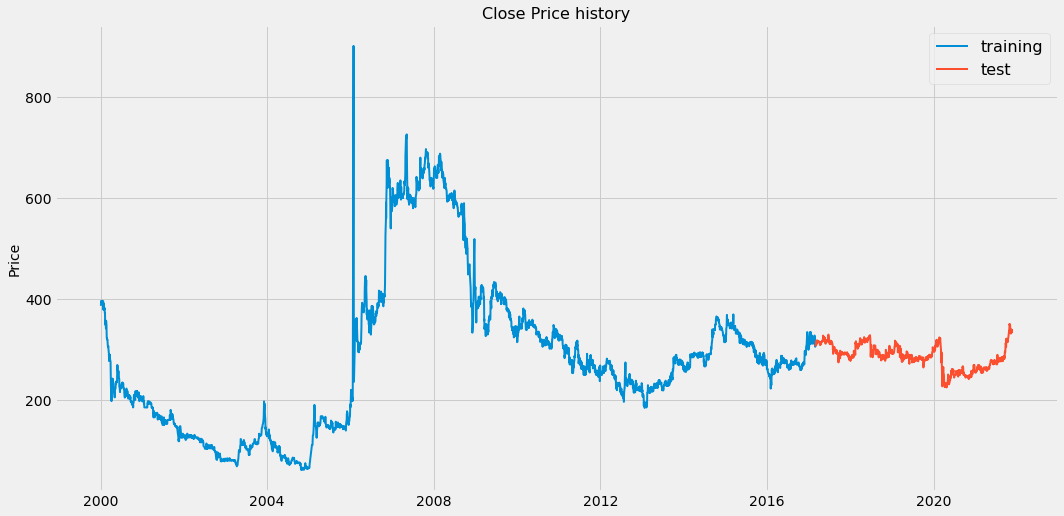

In [4]:
def line_plot(line1, line2, label1=None, label2=None, title='Close Price history', lw=2):
    fig, ax = plt.subplots(1, figsize=(16, 8))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('Price', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16)
    plt.show()

line_plot(train[target_col], test[target_col], 'training', 'test', title='Close Price history')

In [5]:
def extract_window_data(df, window_len=5, zero_base=True):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            X = tmp.values
            # X = preprocessing.scale(X)
            X = scaler.fit_transform(X)
        window_data.append(X)
    return np.array(window_data)

In [6]:
def prepare_data(df, target_col, window_len=5, zero_base=True, test_size=0.2):
    train_data, test_data = train_test_split(df, test_size=test_size)
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1
    return train_data, test_data, X_train, X_test, y_train, y_test

In [7]:
train, test, X_train, X_test, y_train, y_test = prepare_data(
    hist, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)

targets = test[target_col][window_len:]

In [8]:
def build_cnn_lstm_model(X_train, y_train, X_test, y_test):
    # The LSTM architecture
    regressorCNNLSTM = Sequential() 
    
    regressorCNNLSTM.add(Conv1D(256, kernel_size=4, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
    regressorCNNLSTM.add(MaxPooling1D(2))

    regressorCNNLSTM.add(LSTM(256, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
    regressorCNNLSTM.add(Dropout(0.2))
    regressorCNNLSTM.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
    regressorCNNLSTM.add(Dropout(0.2))
    regressorCNNLSTM.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
    regressorCNNLSTM.add(Dropout(0.2))
    regressorCNNLSTM.add(Dense(32,kernel_initializer="uniform",activation='relu'))        
    regressorCNNLSTM.add(Dense(1,kernel_initializer="uniform",activation='linear'))
    regressorCNNLSTM.add(Activation("linear"))

    regressorCNNLSTM.compile(loss="mean_squared_error", optimizer="adam", metrics=['accuracy'])
    regressorCNNLSTM.fit(X_train, y_train, epochs=100, batch_size=96)
    cnn_lstm_pred = regressorCNNLSTM.predict(X_test).squeeze()

    cnn_lstm_MSE = mean_squared_error(y_test, cnn_lstm_pred)
    cnn_lstm_MAE = mean_absolute_error(y_test, cnn_lstm_pred)
    cnn_lstm_RMSE = np.sqrt(np.mean(np.power((np.array(y_test)-np.array(cnn_lstm_pred)),2)))
    print('CNN LSTM Mean Absolute Error: {}'.format(cnn_lstm_MAE))
    print('CNN LSTM MSE: {}'.format(cnn_lstm_MSE))
    print('CNN LSTM RMSE: {}'.format(cnn_lstm_RMSE))

    return regressorCNNLSTM, cnn_lstm_pred, cnn_lstm_MSE, cnn_lstm_MAE, cnn_lstm_RMSE

In [9]:
regressorCNNLSTM, cnn_lstm_pred, cnn_lstm_MSE, cnn_lstm_MAE, cnn_lstm_RMSE = build_cnn_lstm_model(X_train, y_train, X_test, y_test)

Epoch 1/100
41/41 [==============================] - 5s 11ms/step - loss: 0.0063 - accuracy: 0.0449
Epoch 2/100
41/41 [==============================] - 0s 11ms/step - loss: 0.0054 - accuracy: 0.0449
Epoch 3/100
41/41 [==============================] - 0s 11ms/step - loss: 0.0051 - accuracy: 0.0449
Epoch 4/100
41/41 [==============================] - 0s 11ms/step - loss: 0.0048 - accuracy: 0.0449
Epoch 5/100
41/41 [==============================] - 0s 12ms/step - loss: 0.0042 - accuracy: 0.0449
Epoch 6/100
41/41 [==============================] - ETA: 0s - loss: 0.0052 - accuracy: 0.04 - 1s 13ms/step - loss: 0.0051 - accuracy: 0.0449
Epoch 7/100
41/41 [==============================] - 0s 12ms/step - loss: 0.0036 - accuracy: 0.0449
Epoch 8/100
41/41 [==============================] - 1s 12ms/step - loss: 0.0029 - accuracy: 0.0449
Epoch 9/100
41/41 [==============================] - 1s 17ms/step - loss: 0.0029 - accuracy: 0.0449
Epoch 10/100
41/41 [==============================] - 1s 1

41/41 [==============================] - 0s 11ms/step - loss: 2.5819e-04 - accuracy: 0.0449
Epoch 80/100
41/41 [==============================] - 0s 12ms/step - loss: 2.5389e-04 - accuracy: 0.0449
Epoch 81/100
41/41 [==============================] - 0s 12ms/step - loss: 2.2574e-04 - accuracy: 0.0449
Epoch 82/100
41/41 [==============================] - 0s 12ms/step - loss: 1.9461e-04 - accuracy: 0.0449
Epoch 83/100
41/41 [==============================] - 0s 12ms/step - loss: 2.4207e-04 - accuracy: 0.0449
Epoch 84/100
41/41 [==============================] - 0s 12ms/step - loss: 1.9639e-04 - accuracy: 0.0449
Epoch 85/100
41/41 [==============================] - 0s 12ms/step - loss: 1.9891e-04 - accuracy: 0.0449
Epoch 86/100
41/41 [==============================] - 0s 12ms/step - loss: 2.9399e-04 - accuracy: 0.0449
Epoch 87/100
41/41 [==============================] - 0s 12ms/step - loss: 2.5766e-04 - accuracy: 0.0449
Epoch 88/100
41/41 [==============================] - 0s 12ms/step -

In [10]:
def build_cnn_bilstm_model(X_train, y_train, X_test, y_test):
    # The Bidirectional LSTM architecture
    regressorCNNBiLSTM = Sequential()    
    
    regressorCNNBiLSTM.add(Conv1D(256, kernel_size=4, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
    regressorCNNBiLSTM.add(MaxPooling1D(2))
    
    regressorCNNBiLSTM.add(Bidirectional(LSTM(256, input_shape=(X_train.shape[1], X_train.shape[2]), dropout=0.2, return_sequences=True)))
    regressorCNNBiLSTM.add(Bidirectional(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), dropout=0.2, return_sequences=True)))
    regressorCNNBiLSTM.add(Bidirectional(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), dropout=0.2, return_sequences=False)))
    regressorCNNBiLSTM.add(Dense(32,kernel_initializer="uniform",activation='relu'))        
    regressorCNNBiLSTM.add(Dense(1,kernel_initializer="uniform",activation='linear'))
    regressorCNNBiLSTM.add(Activation("linear"))

    regressorCNNBiLSTM.compile(loss="mean_squared_error", optimizer="adam", metrics=['accuracy'])
    regressorCNNBiLSTM.fit(X_train, y_train, epochs=100, batch_size=96)
    cnn_bilstm_pred = regressorCNNBiLSTM.predict(X_test).squeeze()

    cnn_bilstm_MSE = mean_squared_error(y_test, cnn_bilstm_pred)
    cnn_bilstm_MAE = mean_absolute_error(y_test, cnn_bilstm_pred)
    cnn_bilstm_RMSE = np.sqrt(np.mean(np.power((np.array(y_test)-np.array(cnn_bilstm_pred)),2)))
    print('CNN Bidirectional LSTM Mean Absolute Error: {}'.format(cnn_bilstm_MAE))
    print('CNN Bidirectional LSTM MSE: {}'.format(cnn_bilstm_MSE))
    print('CNN Bidirectional LSTM RMSE: {}'.format(cnn_bilstm_RMSE))

    return regressorCNNBiLSTM, cnn_bilstm_pred, cnn_bilstm_MSE, cnn_bilstm_MAE, cnn_bilstm_RMSE

In [11]:
regressorCNNBiLSTM, cnn_bilstm_pred, cnn_bilstm_MSE, cnn_bilstm_MAE, cnn_bilstm_RMSE = build_cnn_bilstm_model(X_train, y_train, X_test, y_test)

Epoch 1/100
41/41 [==============================] - 9s 25ms/step - loss: 0.0060 - accuracy: 0.0449
Epoch 2/100
41/41 [==============================] - 1s 25ms/step - loss: 0.0052 - accuracy: 0.0449
Epoch 3/100
41/41 [==============================] - 1s 25ms/step - loss: 0.0049 - accuracy: 0.0449
Epoch 4/100
41/41 [==============================] - 1s 27ms/step - loss: 0.0048 - accuracy: 0.0449
Epoch 5/100
41/41 [==============================] - 1s 25ms/step - loss: 0.0046 - accuracy: 0.0449
Epoch 6/100
41/41 [==============================] - 1s 27ms/step - loss: 0.0041 - accuracy: 0.0449
Epoch 7/100
41/41 [==============================] - 1s 26ms/step - loss: 0.0039 - accuracy: 0.0449
Epoch 8/100
41/41 [==============================] - 1s 35ms/step - loss: 0.0038 - accuracy: 0.0449
Epoch 9/100
41/41 [==============================] - 1s 29ms/step - loss: 0.0020 - accuracy: 0.0449
Epoch 10/100
41/41 [==============================] - 1s 34ms/step - loss: 0.0018 - accuracy: 0.0449

41/41 [==============================] - 1s 24ms/step - loss: 0.0048 - accuracy: 0.0449
Epoch 81/100
41/41 [==============================] - 1s 24ms/step - loss: 0.0054 - accuracy: 0.0449
Epoch 82/100
41/41 [==============================] - 1s 23ms/step - loss: 0.0050 - accuracy: 0.0449
Epoch 83/100
41/41 [==============================] - 1s 24ms/step - loss: 0.0047 - accuracy: 0.0449
Epoch 84/100
41/41 [==============================] - 1s 23ms/step - loss: 0.0042 - accuracy: 0.0449
Epoch 85/100
41/41 [==============================] - 1s 24ms/step - loss: 0.0040 - accuracy: 0.0449
Epoch 86/100
41/41 [==============================] - 1s 23ms/step - loss: 0.0028 - accuracy: 0.0449
Epoch 87/100
41/41 [==============================] - 1s 23ms/step - loss: 0.0018 - accuracy: 0.0449
Epoch 88/100
41/41 [==============================] - 1s 23ms/step - loss: 0.0016 - accuracy: 0.0449
Epoch 89/100
41/41 [==============================] - 1s 24ms/step - loss: 0.0017 - accuracy: 0.0449
Epo

In [12]:
def build_cnn_gru_model(X_train, y_train, X_test, y_test):
    # The GRU architecture
    regressorCNNGRU = Sequential()
    
    regressorCNNGRU.add(Conv1D(256, kernel_size=4, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
    regressorCNNGRU.add(MaxPooling1D(2))
    
    regressorCNNGRU.add(GRU(256, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
    regressorCNNGRU.add(Dropout(0.2))
    regressorCNNGRU.add(GRU(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
    regressorCNNGRU.add(Dropout(0.2))
    regressorCNNGRU.add(GRU(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
    regressorCNNGRU.add(Dropout(0.2))
    regressorCNNGRU.add(Dense(32,kernel_initializer="uniform",activation='relu'))        
    regressorCNNGRU.add(Dense(1,kernel_initializer="uniform",activation='linear'))
    regressorCNNGRU.add(Activation("linear"))
    
    regressorCNNGRU.compile(loss="mean_squared_error", optimizer="adam", metrics=['accuracy'])
    regressorCNNGRU.fit(X_train, y_train, epochs=100, batch_size=96)
    cnn_gru_pred = regressorCNNGRU.predict(X_test).squeeze()

    cnn_gru_MSE = mean_squared_error(y_test, cnn_gru_pred)
    cnn_gru_MAE = mean_absolute_error(y_test, cnn_gru_pred)
    cnn_gru_RMSE = np.sqrt(np.mean(np.power((np.array(y_test)-np.array(cnn_gru_pred)),2)))
    print('CNN GRU Mean Absolute Error: {}'.format(cnn_gru_MAE))
    print('CNN GRU MSE: {}'.format(cnn_gru_MSE))
    print('CNN GRU RMSE: {}'.format(cnn_gru_RMSE))
    
    return regressorCNNGRU, cnn_gru_pred, cnn_gru_MSE, cnn_gru_MAE, cnn_gru_RMSE

In [13]:
regressorCNNGRU, cnn_gru_pred, cnn_gru_MSE, cnn_gru_MAE, cnn_gru_RMSE = build_cnn_gru_model(X_train, y_train, X_test, y_test)

Epoch 1/100
41/41 [==============================] - 5s 10ms/step - loss: 0.0059 - accuracy: 0.0449
Epoch 2/100
41/41 [==============================] - 0s 10ms/step - loss: 0.0053 - accuracy: 0.0449
Epoch 3/100
41/41 [==============================] - 0s 10ms/step - loss: 0.0050 - accuracy: 0.0449
Epoch 4/100
41/41 [==============================] - 0s 10ms/step - loss: 0.0047 - accuracy: 0.0449
Epoch 5/100
41/41 [==============================] - 0s 10ms/step - loss: 0.0041 - accuracy: 0.0449
Epoch 6/100
41/41 [==============================] - 0s 10ms/step - loss: 0.0052 - accuracy: 0.0449
Epoch 7/100
41/41 [==============================] - 0s 10ms/step - loss: 0.0045 - accuracy: 0.0449
Epoch 8/100
41/41 [==============================] - 0s 10ms/step - loss: 0.0041 - accuracy: 0.0449
Epoch 9/100
41/41 [==============================] - 0s 10ms/step - loss: 0.0038 - accuracy: 0.0449 0s - loss: 0.0020 - accuracy: 
Epoch 10/100
41/41 [==============================] - 0s 10ms/step - 

41/41 [==============================] - 0s 10ms/step - loss: 4.5377e-04 - accuracy: 0.0449
Epoch 79/100
41/41 [==============================] - 0s 10ms/step - loss: 4.6006e-04 - accuracy: 0.0449
Epoch 80/100
41/41 [==============================] - ETA: 0s - loss: 5.0056e-04 - accuracy: 0.04 - 0s 10ms/step - loss: 5.0090e-04 - accuracy: 0.0449
Epoch 81/100
41/41 [==============================] - 0s 10ms/step - loss: 4.3914e-04 - accuracy: 0.0449 0s - loss: 4.6993e-04 - accu
Epoch 82/100
41/41 [==============================] - 0s 10ms/step - loss: 4.2180e-04 - accuracy: 0.0449
Epoch 83/100
41/41 [==============================] - 0s 10ms/step - loss: 4.4230e-04 - accuracy: 0.0449
Epoch 84/100
41/41 [==============================] - 0s 10ms/step - loss: 5.2768e-04 - accuracy: 0.0449
Epoch 85/100
41/41 [==============================] - 0s 10ms/step - loss: 4.3094e-04 - accuracy: 0.0449
Epoch 86/100
41/41 [==============================] - 0s 10ms/step - loss: 6.6257e-04 - accuracy: 

In [14]:
def build_cnn_rnn_model(X_train, y_train, X_test, y_test):
    # The RNN architecture
    regressorCNNRNN = Sequential()
    
    regressorCNNRNN.add(Conv1D(256, kernel_size=4, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
    regressorCNNRNN.add(MaxPooling1D(2))
    
    regressorCNNRNN.add(SimpleRNN(256, return_sequences=True))
    regressorCNNRNN.add(SimpleRNN(128, return_sequences=True))
    regressorCNNRNN.add(SimpleRNN(64, return_sequences=True))
    regressorCNNRNN.add(SimpleRNN(32))
    regressorCNNRNN.add(Dense(1))
    regressorCNNRNN.add(Activation("linear"))

    regressorCNNRNN.compile(loss="mean_squared_error", optimizer="adam", metrics=['accuracy'])
    regressorCNNRNN.fit(X_train, y_train, epochs=100, batch_size=96)
    cnn_rnn_pred = regressorCNNRNN.predict(X_test).squeeze()

    cnn_rnn_MSE = mean_squared_error(y_test, cnn_rnn_pred)
    cnn_rnn_MAE = mean_absolute_error(y_test, cnn_rnn_pred)
    cnn_rnn_RMSE = np.sqrt(np.mean(np.power((np.array(y_test)-np.array(cnn_rnn_pred)),2)))
    print('CNN RNN Mean Absolute Error: {}'.format(cnn_rnn_MAE))
    print('CNN RNN MSE: {}'.format(cnn_rnn_MSE))
    print('CNN RNN RMSE: {}'.format(cnn_rnn_RMSE))

    return regressorCNNRNN, cnn_rnn_pred, cnn_rnn_MSE, cnn_rnn_MAE, cnn_rnn_RMSE

In [15]:
regressorCNNRNN, cnn_rnn_pred, cnn_rnn_MSE, cnn_rnn_MAE, cnn_rnn_RMSE = build_cnn_rnn_model(X_train, y_train, X_test, y_test)

Epoch 1/100
41/41 [==============================] - 2s 5ms/step - loss: 0.1072 - accuracy: 0.0436
Epoch 2/100
41/41 [==============================] - 0s 5ms/step - loss: 0.0063 - accuracy: 0.0449
Epoch 3/100
41/41 [==============================] - 0s 4ms/step - loss: 0.0056 - accuracy: 0.0449
Epoch 4/100
41/41 [==============================] - 0s 4ms/step - loss: 0.0055 - accuracy: 0.0449
Epoch 5/100
41/41 [==============================] - 0s 4ms/step - loss: 0.0053 - accuracy: 0.0449
Epoch 6/100
41/41 [==============================] - 0s 5ms/step - loss: 0.0052 - accuracy: 0.0449
Epoch 7/100
41/41 [==============================] - 0s 4ms/step - loss: 0.0052 - accuracy: 0.0449
Epoch 8/100
41/41 [==============================] - 0s 5ms/step - loss: 0.0051 - accuracy: 0.0449
Epoch 9/100
41/41 [==============================] - 0s 5ms/step - loss: 0.0050 - accuracy: 0.0449
Epoch 10/100
41/41 [==============================] - 0s 4ms/step - loss: 0.0050 - accuracy: 0.0449
Epoch 11/

41/41 [==============================] - 0s 5ms/step - loss: 3.8255e-04 - accuracy: 0.0449
Epoch 82/100
41/41 [==============================] - ETA: 0s - loss: 3.4173e-04 - accuracy: 0.04 - 0s 5ms/step - loss: 3.4972e-04 - accuracy: 0.0449
Epoch 83/100
41/41 [==============================] - 0s 4ms/step - loss: 3.1242e-04 - accuracy: 0.0449
Epoch 84/100
41/41 [==============================] - ETA: 0s - loss: 3.3837e-04 - accuracy: 0.04 - 0s 5ms/step - loss: 3.4667e-04 - accuracy: 0.0449
Epoch 85/100
41/41 [==============================] - 0s 4ms/step - loss: 4.7827e-04 - accuracy: 0.0449
Epoch 86/100
41/41 [==============================] - 0s 4ms/step - loss: 3.9687e-04 - accuracy: 0.0449
Epoch 87/100
41/41 [==============================] - 0s 5ms/step - loss: 6.0928e-04 - accuracy: 0.0449
Epoch 88/100
41/41 [==============================] - 0s 5ms/step - loss: 4.5192e-04 - accuracy: 0.0449
Epoch 89/100
41/41 [==============================] - 0s 5ms/step - loss: 3.1906e-04 - ac

In [16]:
cnn_lstm_pred = test[target_col].values[:-window_len] * (cnn_lstm_pred + 1)
cnn_lstm_pred = pd.Series(index=targets.index, data=cnn_lstm_pred)

cnn_bilstm_pred = test[target_col].values[:-window_len] * (cnn_bilstm_pred + 1)
cnn_bilstm_pred = pd.Series(index=targets.index, data=cnn_bilstm_pred)

cnn_gru_pred = test[target_col].values[:-window_len] * (cnn_gru_pred + 1)
cnn_gru_pred = pd.Series(index=targets.index, data=cnn_gru_pred)

cnn_rnn_pred = test[target_col].values[:-window_len] * (cnn_rnn_pred + 1)
cnn_rnn_pred = pd.Series(index=targets.index, data=cnn_rnn_pred)

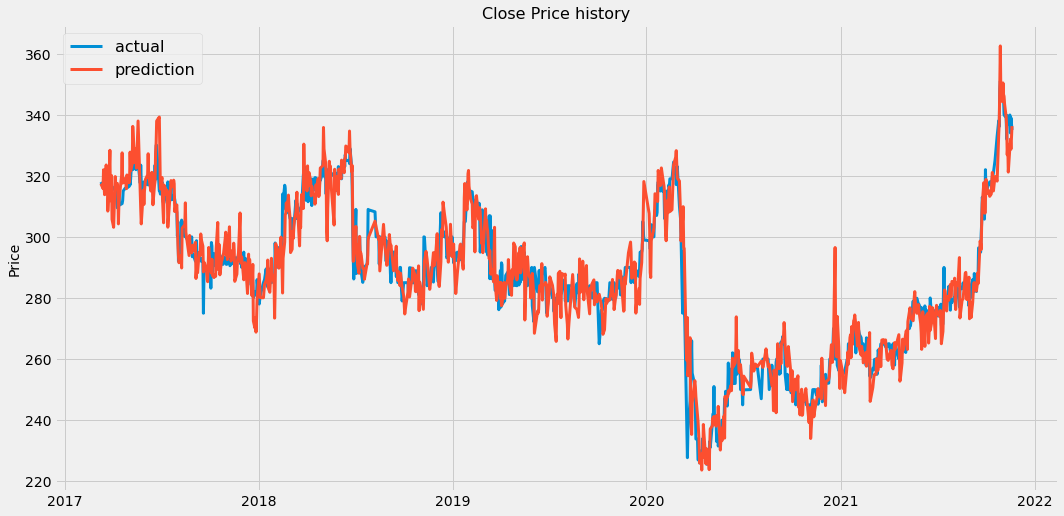

In [17]:
line_plot(targets, cnn_lstm_pred, 'actual', 'prediction', lw=3)

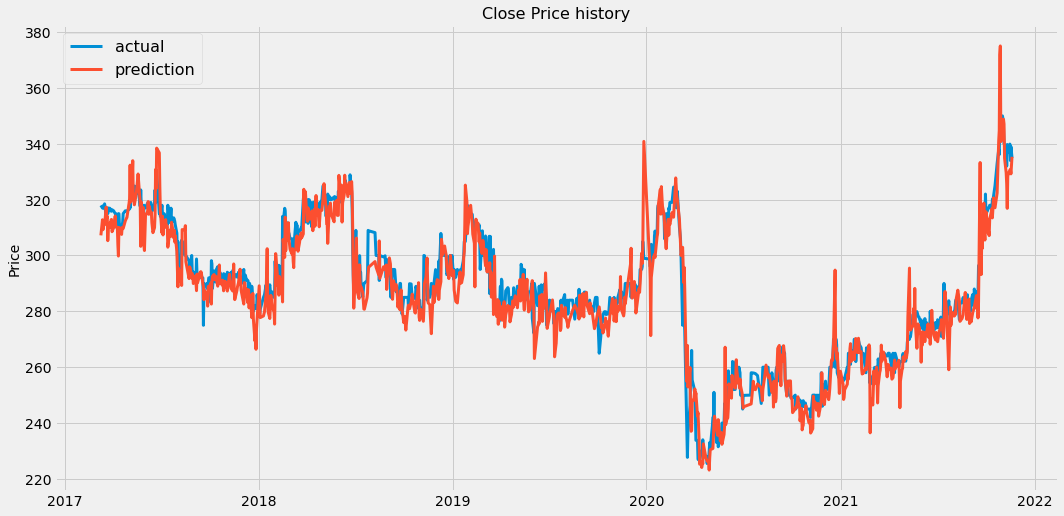

In [18]:
line_plot(targets, cnn_bilstm_pred, 'actual', 'prediction', lw=3)

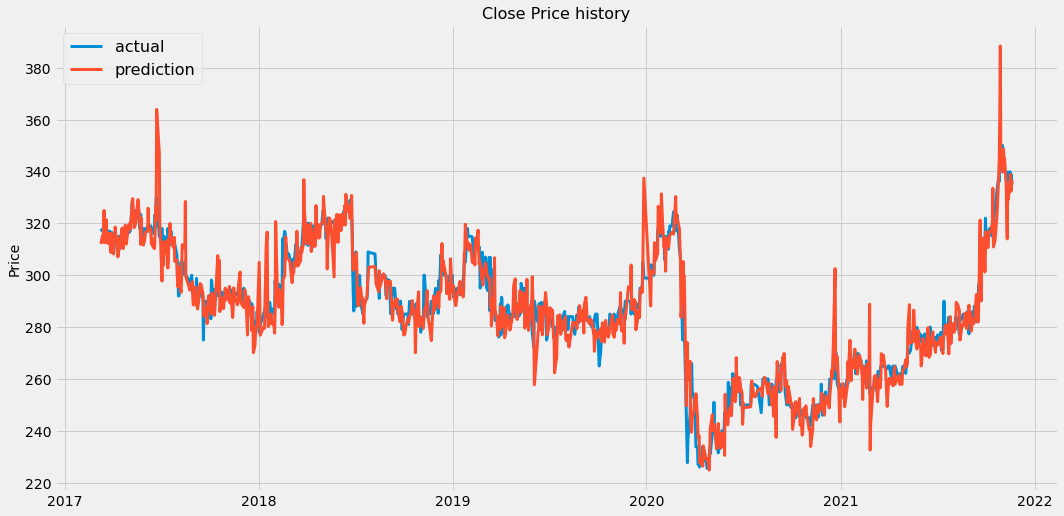

In [19]:
line_plot(targets, cnn_gru_pred, 'actual', 'prediction', lw=3)

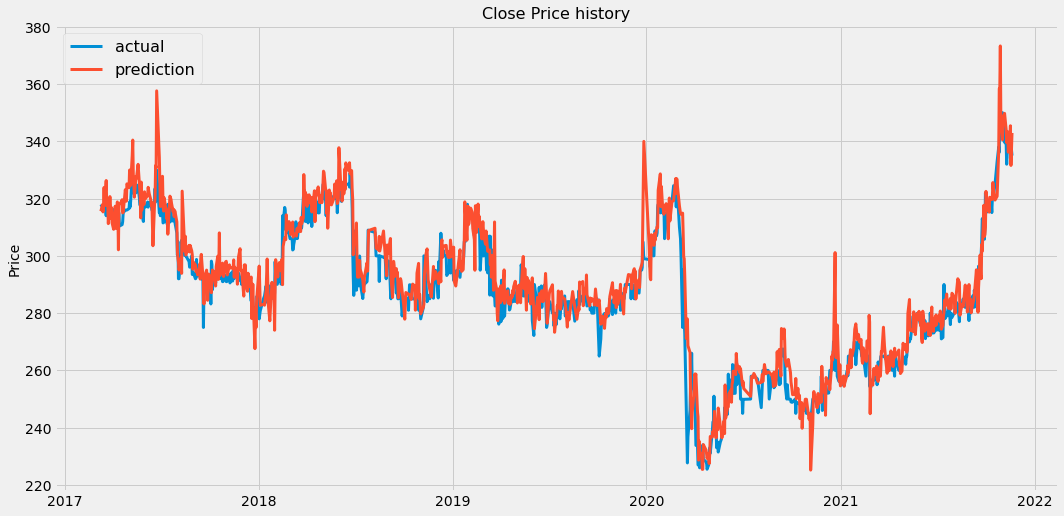

In [20]:
line_plot(targets, cnn_rnn_pred, 'actual', 'prediction', lw=3)

In [21]:
result = pd.concat([test[target_col], cnn_lstm_pred, cnn_bilstm_pred, cnn_gru_pred, cnn_rnn_pred], axis=1)
result.rename(columns={result.columns[0]:'Close Test'}, inplace=True)
result.rename(columns={result.columns[1]:'Close CNN LSTM'}, inplace=True)
result.rename(columns={result.columns[2]:'Close CNN BiLSTM'}, inplace=True)
result.rename(columns={result.columns[3]:'Close CNN GRU'}, inplace=True)
result.rename(columns={result.columns[4]:'Close CNN RNN'}, inplace=True)

In [22]:
result = result.dropna()
result

,Close Test,Close CNN LSTM,Close CNN BiLSTM,Close CNN GRU,Close CNN RNN
Date,,,,,
2017-03-10,317.95,317.370635,307.209868,312.029056,315.589025
2017-03-13,317.00,316.208161,312.803878,315.187320,317.879039
2017-03-14,316.90,315.842477,309.239551,312.850945,315.337764
2017-03-15,317.90,321.970792,311.722820,317.990867,317.943967
2017-03-16,317.30,316.472784,312.337009,324.948230,323.887991
...,...,...,...,...,...
2021-11-12,337.00,321.209701,329.219447,329.185067,336.197290
2021-11-15,339.90,328.980079,330.587445,335.013523,341.088974
2021-11-16,334.00,332.006689,330.821086,338.848963,345.425830


In [23]:
#result.to_excel("result_lstm_gru_rnn.xlsx")

In [24]:
cnn_lstm_MAPE = mean_absolute_percentage_error(result["Close Test"], result["Close CNN LSTM"])
cnn_bilstm_MAPE = mean_absolute_percentage_error(result["Close Test"], result["Close CNN BiLSTM"])
cnn_gru_MAPE = mean_absolute_percentage_error(result["Close Test"], result["Close CNN GRU"])
cnn_rnn_MAPE = mean_absolute_percentage_error(result["Close Test"], result["Close CNN RNN"])

In [25]:
cnames=['CNN LSTM', 'CNN BiLSTM', 'CNN GRU', 'CNN RNN']
finalResult = pd.DataFrame(columns=cnames, index=["MAE", "MSE", "RMSE", "MAPE"])

In [26]:
finalResult["CNN LSTM"]["MAE"] = cnn_lstm_MAE
finalResult["CNN LSTM"]["MSE"] = cnn_lstm_MSE
finalResult["CNN LSTM"]["RMSE"] = cnn_lstm_RMSE
finalResult["CNN LSTM"]["MAPE"] = cnn_lstm_MAPE

finalResult["CNN BiLSTM"]["MAE"] = cnn_bilstm_MAE
finalResult["CNN BiLSTM"]["MSE"] = cnn_bilstm_MSE
finalResult["CNN BiLSTM"]["RMSE"] = cnn_bilstm_RMSE
finalResult["CNN BiLSTM"]["MAPE"] = cnn_bilstm_MAPE

finalResult["CNN GRU"]["MAE"] = cnn_gru_MAE
finalResult["CNN GRU"]["MSE"] = cnn_gru_MSE
finalResult["CNN GRU"]["RMSE"] = cnn_gru_RMSE
finalResult["CNN GRU"]["MAPE"] = cnn_gru_MAPE

finalResult["CNN RNN"]["MAE"] = cnn_rnn_MAE
finalResult["CNN RNN"]["MSE"] = cnn_rnn_MSE
finalResult["CNN RNN"]["RMSE"] = cnn_rnn_RMSE
finalResult["CNN RNN"]["MAPE"] = cnn_rnn_MAPE

In [27]:
finalResult

,CNN LSTM,CNN BiLSTM,CNN GRU,CNN RNN
MAE,0.018466,0.019392,0.018944,0.017971
MSE,0.000605,0.000695,0.000733,0.000659
RMSE,0.024606,0.026354,0.027065,0.02567
MAPE,0.018553,0.019386,0.019,0.018159


In [28]:
#finalResult.to_excel("finalResult_cnn_lstm_bilstm_gru_rnn.xlsx")